In [1]:
import numpy as np
import pandas as pd

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from mlxtend.evaluate import plot_decision_regions

from matplotlib import pyplot as plt
%matplotlib inline

## Total and explained variance

In [2]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data", header=None)

In [3]:
X, y = df.iloc[:, 1:].values, df.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [4]:
cov_mat = np.cov(X_train_std, rowvar=0) # hmmmmmm
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues\n%s' % eigen_vals)


Eigenvalues
[ 4.8923083   2.46635032  1.42809973  1.01233462  0.84906459  0.60181514
  0.52251546  0.33051429  0.08414846  0.29595018  0.16831254  0.21432212
  0.2399553 ]


In [5]:
tot = sum(eigen_vals)
var_exp = [(i/tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

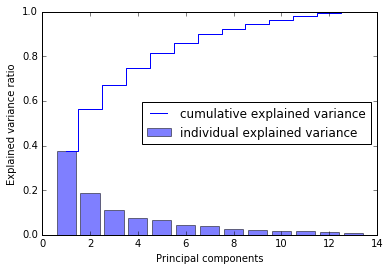

In [6]:
plt.bar(range(1, 14), var_exp, alpha=.5, align='center', label='individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')

## Feature transformation

In [7]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(reverse=True)

In [8]:
w = np.c_[eigen_pairs[0][1], eigen_pairs[1][1]]
print('Matrix W:\n', w)

Matrix W:
 [[-0.14669811  0.50417079]
 [ 0.24224554  0.24216889]
 [ 0.02993442  0.28698484]
 [ 0.25519002 -0.06468718]
 [-0.12079772  0.22995385]
 [-0.38934455  0.09363991]
 [-0.42326486  0.01088622]
 [ 0.30634956  0.01870216]
 [-0.30572219  0.03040352]
 [ 0.09869191  0.54527081]
 [-0.30032535 -0.27924322]
 [-0.36821154 -0.174365  ]
 [-0.29259713  0.36315461]]


In [9]:
X_train_std[0].dot(w)

array([-2.59891628,  0.00484089])

In [10]:
X_train_pca = X_train_std.dot(w)

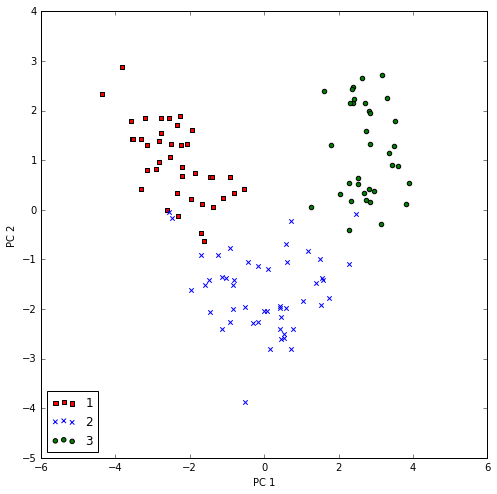

In [11]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

_ = plt.figure(figsize=(8, 8))
for l, c, m in zip(np.unique(y_train), colors, markers): # estranho dar unique quando sei -> se o dataset tiver oo registros rs
    plt.scatter(X_train_pca[y_train==l, 0],
                X_train_pca[y_train==l, 1],
                c=c, label=l, marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')

## Principal componente analysis in scikit-learn

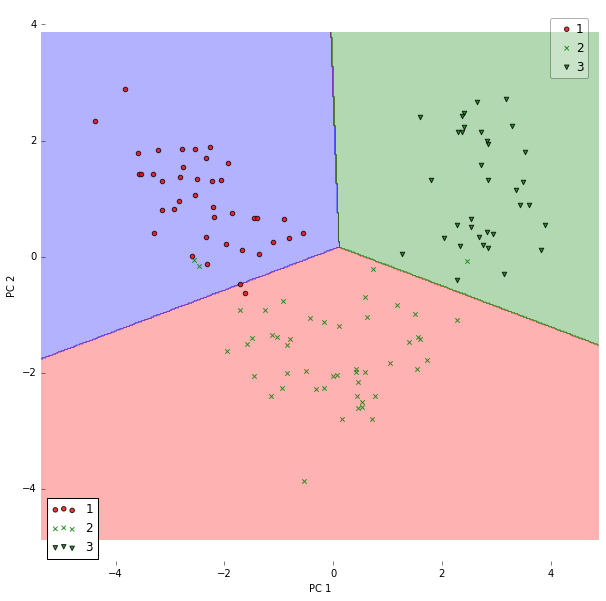

In [12]:
pca = PCA(n_components=2)
lr = LogisticRegression()

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr.fit(X_train_pca, y_train)

_, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_decision_regions(X_train_pca, y_train, lr, ax=ax, colors='blue,red,green,yellow', markers='oxv')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
# duno pq os símbolos do 2 e 3 estão com mesma cor...

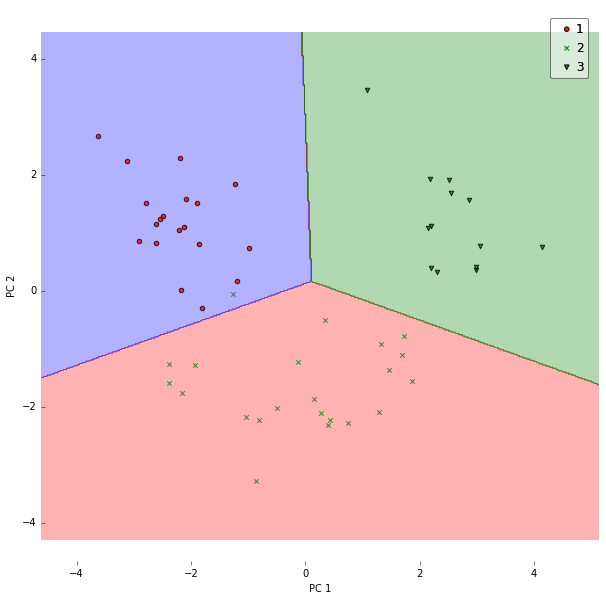

In [13]:
_, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_decision_regions(X_test_pca, y_test, lr, ax=ax, colors='blue,red,green,yellow', markers='oxv')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

In [14]:
# explained variance ration
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([ 0.37329648,  0.18818926,  0.10896791,  0.07724389,  0.06478595,
        0.04592014,  0.03986936,  0.02521914,  0.02258181,  0.01830924,
        0.01635336,  0.01284271,  0.00642076])

<Container object of 13 artists>

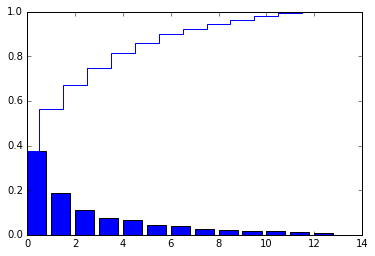

In [15]:
plt.step(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

## Supervised data compression via linear discriminant analysis

In [16]:
np.set_printoptions(precision=4)

mean_vecs = [np.mean(X_train_std[y_train==label], axis=0) for label in range(1, 4)]

for label, mean_vec in zip(range(1,4), mean_vecs):
    
    print('MV %s: %s\n' % (label, mean_vec))

MV 1: [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

MV 2: [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

MV 3: [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



In [17]:
d = X_train_std.shape[1]
S_W = np.zeros((d, d))

for label, mv in zip(range(1, 4), mean_vecs):
    
    class_scatter = np.zeros_like(S_W)
    for row in X_train[y_train == label]:
        
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
        
    S_W += class_scatter

print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


In [18]:
print('Class label distribution: %s' % np.bincount(y_train)[1:])

Class label distribution: [40 49 35]


In [19]:
d = X_train_std.shape[1]
S_W = np.zeros((d, d))

for label, mv in zip(range(1, 4), mean_vecs):
    
    class_scatter = np.cov(X_train_std[y_train==label].T)
        
    S_W += class_scatter

print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


In [20]:
mean_overall = np.mean(X_train_std, axis=0)
S_B = np.zeros((d, d))

for i, mean_vec in enumerate(mean_vecs):
    
    n = X_train[y_train == i+1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
    
print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


### Selecting linear discriminants for the new feature subspace

In [21]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [22]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

print('Eigenvalues in decreasing order:\n')

for eigen_pair in eigen_pairs:
    
    print(eigen_pair[0])

Eigenvalues in decreasing order:

452.721581245
156.43636122
8.11811809613e-14
2.68006957712e-14
2.68006957712e-14
2.39982713607e-14
2.39982713607e-14
1.99648402493e-14
1.34750688434e-14
1.34750688434e-14
1.03876685512e-14
6.18969492552e-15
5.40039260019e-17


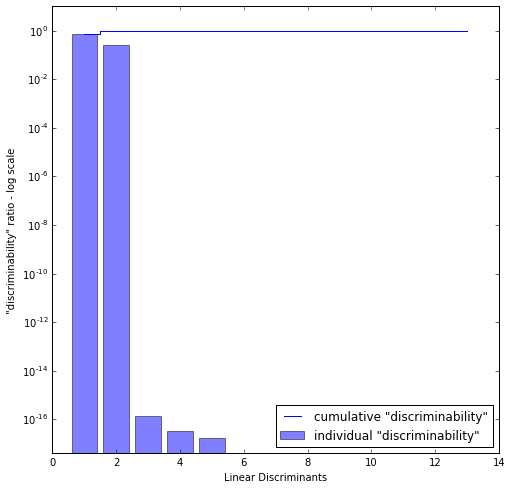

In [23]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

_ = plt.figure(figsize=(8, 8))
plt.bar(range(1, 14), discr, alpha=.5, align='center', label='individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid', label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio - log scale')
plt.xlabel('Linear Discriminants')
plt.yscale('log')
plt.ylim([-.1, 10.])
plt.legend(loc='best')

In [24]:
w = np.c_[eigen_pairs[0][1], eigen_pairs[1][1]].real

print('Matrix W:\n', w)

Matrix W:
 [[ 0.0662 -0.3797]
 [-0.0386 -0.2206]
 [ 0.0217 -0.3816]
 [-0.184   0.3018]
 [ 0.0034  0.0141]
 [-0.2326  0.0234]
 [ 0.7747  0.1869]
 [ 0.0811  0.0696]
 [-0.0875  0.1796]
 [-0.185  -0.284 ]
 [ 0.066   0.2349]
 [ 0.3805  0.073 ]
 [ 0.3285 -0.5971]]


### Projecting samples onto the new feature space

In [25]:
'rbg'.split()

['rbg']

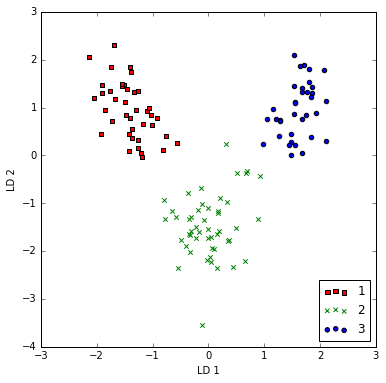

In [26]:
X_train_lda = X_train_std.dot(w)

_ = plt.figure(figsize=(6, 6))
for l, c, m in zip(np.unique(y_train), 'rgb', 'sxo'):
    
    plt.scatter(X_train_lda[y_train==l, 0]*(-1),
                X_train_lda[y_train==l, 1]*(-1),
                c=c, label=l, marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')

## LDA via scikit-learn

In [27]:
from sklearn.lda import LDA

lda = LDA(n_components=2)

X_train_lda = lda.fit_transform(X_train_std, y_train)

/home/abevieiramota/anaconda3/lib/python3.5/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


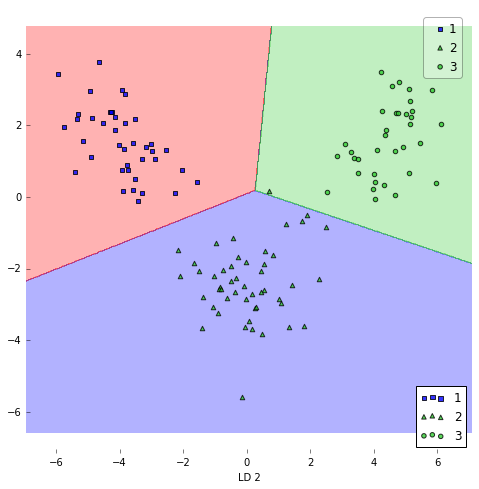

In [28]:
lr = LogisticRegression().fit(X_train_lda, y_train)

_ = plt.figure(figsize=(8, 8))
plot_decision_regions(X_train_lda, y_train, lr)
plt.xlabel('LD 1')
plt.xlabel('LD 2')
plt.legend(loc='lower right')

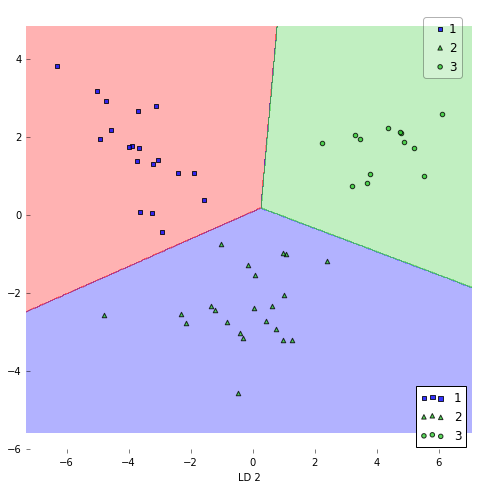

In [29]:
X_test_lda = lda.transform(X_test_std)

_ = plt.figure(figsize=(8, 8))

plot_decision_regions(X_test_lda, y_test, lr)
plt.xlabel('LD 1')
plt.xlabel('LD 2')
plt.legend(loc='lower right')

## Implementing a kernel principal component analysis in Python

In [43]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh

def rbf_kernel_pca(X, gamma, n_components):
    
    sq_dists = pdist(X, 'sqeuclidean')
    
    mat_sq_dists = squareform(sq_dists)
    
    K = exp(-gamma * mat_sq_dists)
    
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    eigvals, eigvecs = eigh(K)
    
    X_pc = np.column_stack((eigvecs[:, -i] for i in range(1, n_components + 1)))
    
    return X_pc

### Example 1- separating half-moon shapes

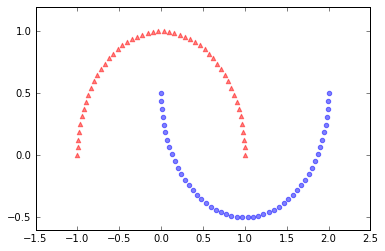

In [31]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=123)

plt.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=.5)

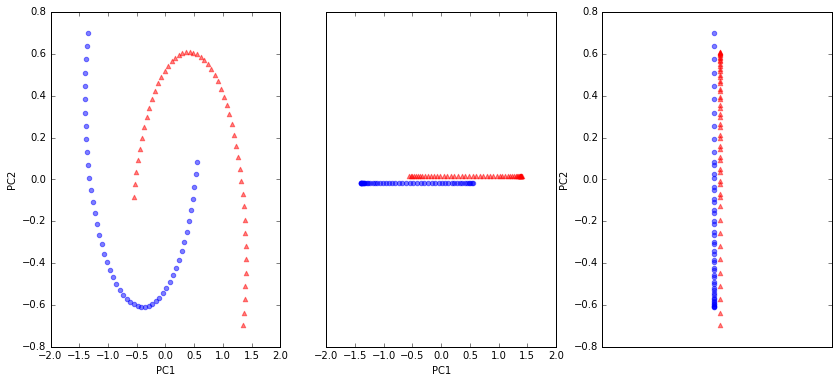

In [40]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))

ax1.scatter(X_spca[y==0, 0], X_spca[y==0, 1], color='red', marker='^', alpha=.5)
ax1.scatter(X_spca[y==1, 0], X_spca[y==1, 1], color='blue', marker='o', alpha=.5)

ax2.scatter(X_spca[y==0, 0], np.zeros((50, 1)) + .02, color='red', marker='^', alpha=.5)
ax2.scatter(X_spca[y==1, 0], np.zeros((50, 1)) - .02, color='blue', marker='o', alpha=.5)

ax3.scatter(np.zeros((50, 1)) + .05, X_spca[y==0, 1], color='red', marker='^', alpha=.5)
ax3.scatter(np.zeros((50, 1)) - .05, X_spca[y==1, 1], color='blue', marker='o', alpha=.5)

ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax2.set_ylim([-1, 1])
ax2.set_yticks([])
ax2.set_xlabel('PC1')
ax3.set_xlim([-2, 2])
ax3.set_xticks([])
ax3.set_ylabel('PC2')

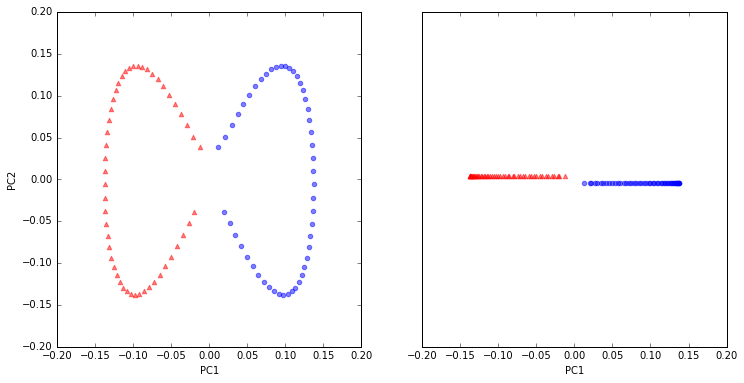

In [44]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], color='red', marker='^', alpha=.5)
ax1.scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], color='blue', marker='o', alpha=.5)

ax2.scatter(X_kpca[y==0, 0], np.zeros((50, 1)) + .02, color='red', marker='^', alpha=.5)
ax2.scatter(X_kpca[y==1, 0], np.zeros((50, 1)) - .02, color='blue', marker='o', alpha=.5)

ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax2.set_ylim([-1, 1])
ax2.set_yticks([])
ax2.set_xlabel('PC1')

### Example 2 - separating concentric circles

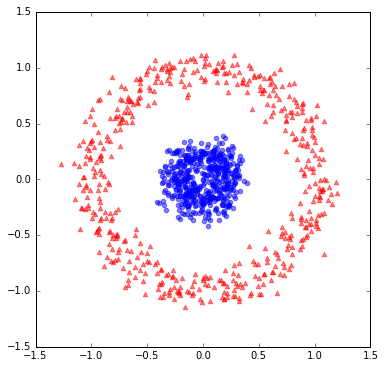

In [50]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=.1, factor=.2)

_ = plt.figure(figsize=(6, 6))
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=.5)

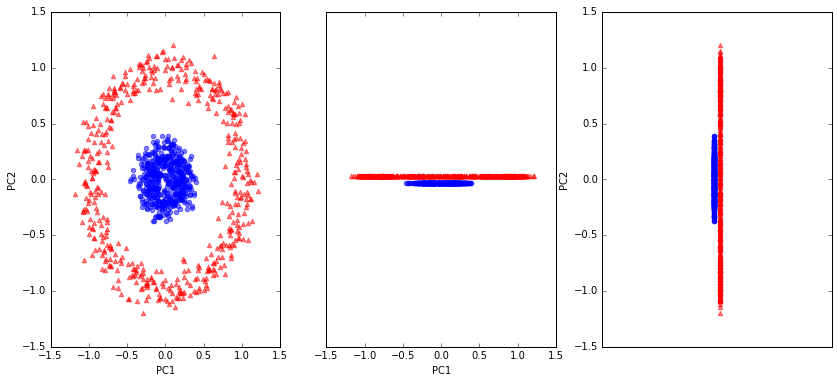

In [52]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))

ax1.scatter(X_spca[y==0, 0], X_spca[y==0, 1], color='red', marker='^', alpha=.5)
ax1.scatter(X_spca[y==1, 0], X_spca[y==1, 1], color='blue', marker='o', alpha=.5)

ax2.scatter(X_spca[y==0, 0], np.zeros((500, 1)) + .02, color='red', marker='^', alpha=.5)
ax2.scatter(X_spca[y==1, 0], np.zeros((500, 1)) - .02, color='blue', marker='o', alpha=.5)

ax3.scatter(np.zeros((500, 1)) + .05, X_spca[y==0, 1], color='red', marker='^', alpha=.5)
ax3.scatter(np.zeros((500, 1)) - .05, X_spca[y==1, 1], color='blue', marker='o', alpha=.5)

ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax2.set_ylim([-1, 1])
ax2.set_yticks([])
ax2.set_xlabel('PC1')
ax3.set_xlim([-2, 2])
ax3.set_xticks([])
ax3.set_ylabel('PC2')

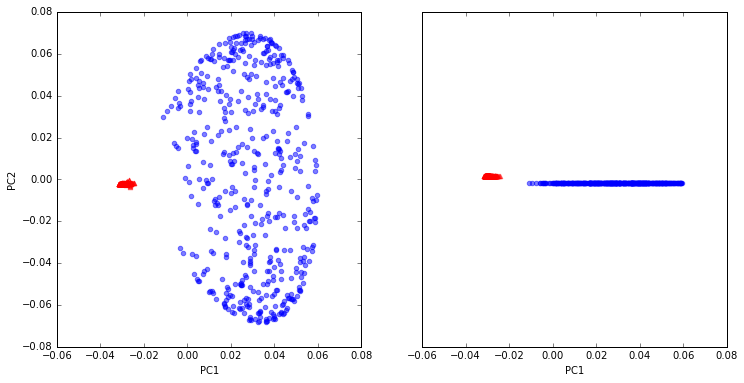

In [53]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], color='red', marker='^', alpha=.5)
ax1.scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], color='blue', marker='o', alpha=.5)

ax2.scatter(X_kpca[y==0, 0], np.zeros((500, 1)) + .02, color='red', marker='^', alpha=.5)
ax2.scatter(X_kpca[y==1, 0], np.zeros((500, 1)) - .02, color='blue', marker='o', alpha=.5)

ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax2.set_ylim([-1, 1])
ax2.set_yticks([])
ax2.set_xlabel('PC1')

## Projecting new data points

In [54]:
def rbf_kernel_pca(X, gamma, n_components):
    
    sq_dists = pdist(X, 'sqeuclidean')
    
    mat_sq_dists = squareform(sq_dists)
    
    K = exp(-gamma * mat_sq_dists)
    
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    eigvals, eigvecs = eigh(K)
    
    alphas = np.column_stack((eigvecs[:, -i] for i in range(1, n_components + 1)))
    
    lambdas = [eigvals[-i] for i in range(1, n_components+1)]
    
    return alphas, lambdas

In [55]:
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1)

In [62]:
x_new = X[25]
x_new

array([ 1.8713,  0.0093])

In [61]:
x_proj = alphas[25]
x_proj

array([ 0.0788])

In [59]:
def project_x(x_new, X, gamma, alphas, lambdas):
    
    pair_dist = np.array([np.sum((x_new - row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    
    return k.dot(alphas / lambdas)

In [64]:
x_reproj = project_x(x_new, X, gamma=15, alphas=alphas, lambdas=lambdas)
x_reproj

array([ 0.0788])

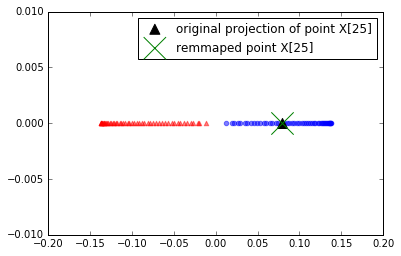

In [68]:
plt.scatter(alphas[y==0, 0], np.zeros((50, 1)), color='red', marker='^', alpha=.5)
plt.scatter(alphas[y==1, 0], np.zeros((50, 1)), color='blue', marker='o', alpha=.5)

plt.scatter(x_proj, 0, color='black', label='original projection of point X[25]', marker='^', s=100)
plt.scatter(x_reproj, 0, color='green', label='remmaped point X[25]', marker='x', s=500)

plt.legend(scatterpoints=1)

## Kernel principal component analysis in scikit-learn

In [72]:
from sklearn.decomposition import KernelPCA

X, y = make_moons(n_samples=100, random_state=123)

scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)

X_skernpca = scikit_kpca.fit_transform(X)

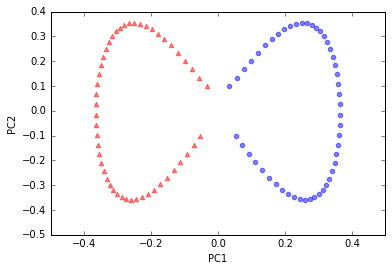

In [74]:
plt.scatter(X_skernpca[y==0, 0], X_skernpca[y==0, 1], color='red', marker='^', alpha=.5)
plt.scatter(X_skernpca[y==1, 0], X_skernpca[y==1, 1], color='blue', marker='o', alpha=.5)

plt.xlabel('PC1')
plt.ylabel('PC2')